<a href="https://colab.research.google.com/github/Sopralapanca/CommonLitChallenge/blob/main/TrainLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!git clone "https://github.com/Sopralapanca/CommonLitChallenge.git"

fatal: destination path 'CommonLitChallenge' already exists and is not an empty directory.


In [74]:
 !pip install --no-cache-dir transformers

In [75]:
!pip install sentencepiece

In [76]:
!pip install accelerate swifter

In [77]:
import swifter

In [78]:
import pandas as pd
import gc

train_path = "/content/CommonLitChallenge/data/dataset.zip"

train_data = pd.read_csv(train_path, compression='zip', sep=',', index_col=0)

In [79]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7165 entries, 3b9047 to 814d6b
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   text                                  7165 non-null   object 
 1   content                               7165 non-null   float64
 2   wording                               7165 non-null   float64
 3   corrected_text                        7165 non-null   object 
 4   distance                              7165 non-null   int64  
 5   corrected_text_preprocessed           7165 non-null   object 
 6   text_pre_withstop                     7165 non-null   object 
 7   corrected_text_pre_withstop           7165 non-null   object 
 8   text_pos                              7165 non-null   float64
 9   summary_entities                      7165 non-null   object 
 10  summary_word_counter                  7165 non-null   int64  
 11  prompt_question

In [80]:
train_data.drop(["semantic_similarity"], inplace=True, axis=1)

In [81]:
train_data.describe()

,content,wording,distance,text_pos,summary_word_counter,prompt_text_word_counter,word_counter_ratio,matching_entities,length_ratio,normalized_text_length,normalized_text_misspelled_counter,normalized_2grams-cooccurrence-count,normalized_2grams-correct-count,normalized_3grams-cooccurrence-count,normalized_3grams-correct-count,normalized_4grams-cooccurrence-count,normalized_4grams-correct-count,normalized_karp_tfidf_scores
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,16.477460,11.406205,29.654571,231.128821,0.130159,1.432938,0.109206,0.098623,0.094414,0.100383,0.111286,0.071267,0.121244,0.062355,0.124346,0.445900
std,1.043569,1.036048,20.365489,1.454342,18.410800,38.433055,0.080600,3.248868,0.083802,0.103031,0.115575,0.103079,0.103958,0.099194,0.104747,0.098944,0.104189,0.228614
min,-1.729859,-1.962614,0.000000,6.101596,6.000000,194.000000,0.027586,0.000000,0.021824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.799545,-0.872720,6.000000,10.271964,17.000000,194.000000,0.075862,0.000000,0.055899,0.030906,0.000000,0.034483,0.042169,0.008130,0.052174,0.000000,0.056140,0.261513
50%,-0.093814,-0.081769,11.000000,11.373350,24.000000,225.000000,0.108247,0.000000,0.083983,0.064380,0.071429,0.067857,0.077889,0.032520,0.088435,0.017094,0.092040,0.416261
75%,0.499660,0.503833,20.000000,12.456622,36.000000,290.000000,0.159794,1.000000,0.131845,0.131569,0.142857,0.128492,0.144695,0.097561,0.157143,0.087379,0.159204,0.605809
max,3.900326,4.310693,532.000000,15.840024,204.000000,290.000000,1.046392,54.000000,1.151697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
from sklearn.preprocessing import MinMaxScaler

def normalize_col(df, col):
    # Create a Min-Max Scaler
    scaler = MinMaxScaler()
    df[col] = df.groupby('prompt_id')[col].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    return df

In [83]:
for col in ["distance",	"text_pos",	"summary_word_counter",	"prompt_text_word_counter",	"word_counter_ratio",	"matching_entities","length_ratio"]:
        train_data = normalize_col(train_data, col)

# Data prepatation for the LLM

In [84]:
def oversample_df(df):
    """
    :param df: Dataframe to be overampled based on prompt_id
    :return: Dataframe oversampled
    """
    classes = df["prompt_id"].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df["prompt_id"] == key])
    classes_sample = []
    for i in range(1, len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe, classes_list[0]], axis=0)

    return final_df

In [85]:
import copy
import numpy as np
import more_itertools

import torch
from torch.utils.data import Sampler, Dataset, DataLoader

class SmartBatchingDataset(Dataset):
    def __init__(self, df, tokenizer, input_cols, features_cols, target_cols=None):
        super(SmartBatchingDataset, self).__init__()

        input_df = copy.deepcopy(df[input_cols])
        features_df = copy.deepcopy(df[features_cols])

        # Combine strings from multiple columns with [CLS], [SEP], and [SEP] separators
        input_df['combined_col'] = input_df.swifter.apply(
            lambda row: tokenizer.cls_token + ' ' + f' {tokenizer.sep_token} '.join(row) + f' {tokenizer.sep_token}',
            axis=1)

        self._data = [
            input_df['combined_col'].swifter.apply(tokenizer.tokenize).swifter.apply(tokenizer.convert_tokens_to_ids).to_list(),
            features_df.values.tolist()]
        self._targets = df[target_cols].values.tolist() if target_cols is not None else None
        self.sampler = None
    def __len__(self):
        return len(self._data)

    def __getitem__(self, item):
        if self._targets is not None:
            return [self._data[0][item], self._data[1][item]], self._targets[item]
        else:
            return [self._data[0][item], self._data[1][item]]

    def get_dataloader(self, batch_size, max_len, pad_id, num_workers=1, test=False):
        collate_fn = SmartBatchingCollate(
            targets=self._targets,
            max_length=max_len,
            pad_token_id=pad_id
        )

        self.sampler = SmartBatchingSampler(
                data_source=self._data[0],
                batch_size=batch_size,
                test=test
            )

        dataloader = DataLoader(
            dataset=self,
            batch_size=batch_size,
            sampler=self.sampler,
            collate_fn=collate_fn,
            pin_memory=True,
            num_workers=num_workers
        )
        return dataloader


class SmartBatchingSampler(Sampler):
    def __init__(self, data_source, batch_size, test=False):
        super(SmartBatchingSampler, self).__init__(data_source)
        self.len = len(data_source)
        self.batch_size = batch_size
        self.test = test

        if not self.test:
            sample_lengths = [len(seq) for seq in data_source]
            argsort_inds = np.argsort(sample_lengths)
            self.batches = list(more_itertools.chunked(argsort_inds, n=batch_size))
            self._backsort_inds = None

    def __iter__(self):
        if not self.test:
            if self.batches:
                last_batch = self.batches.pop(-1)
                np.random.shuffle(self.batches)
                self.batches.append(last_batch)
            self._inds = list(more_itertools.flatten(self.batches))
            yield from self._inds
        else:
            yield from range(self.len)

    def __len__(self):
        return self.len

    @property
    def backsort_inds(self):
        if not self.test and self._backsort_inds is None:
            self._backsort_inds = np.argsort(self._inds)
        return self._backsort_inds


class SmartBatchingCollate:
    def __init__(self, targets, max_length, pad_token_id):
        self._targets = targets
        self._max_length = max_length
        self._pad_token_id = pad_token_id

    def __call__(self, batch):
        if self._targets is not None:
            sequences, targets = list(zip(*batch))
        else:
            sequences = list(batch)

        ids = []
        features = []
        for i in range(len(sequences)):
            ids.append(sequences[i][0])
            features.append(sequences[i][1])

        input_ids, attention_mask = self.pad_sequence(
            ids,
            max_sequence_length=self._max_length,
            pad_token_id=self._pad_token_id
        )

        if self._targets is not None:
            output = [input_ids, features], attention_mask, torch.tensor(targets)
        else:
            output = [input_ids, features], attention_mask
        return output

    def pad_sequence(self, sequence_batch, max_sequence_length, pad_token_id):
        max_batch_len = max(len(sequence) for sequence in sequence_batch)
        max_len = min(max_batch_len, max_sequence_length)
        padded_sequences, attention_masks = [[] for i in range(2)]
        attend, no_attend = 1, 0
        for sequence in sequence_batch:
            # As discussed above, truncate if exceeds max_len
            new_sequence = list(sequence[:max_len])

            attention_mask = [attend] * len(new_sequence)
            pad_length = max_len - len(new_sequence)

            new_sequence.extend([pad_token_id] * pad_length)
            attention_mask.extend([no_attend] * pad_length)

            padded_sequences.append(new_sequence)
            attention_masks.append(attention_mask)

        padded_sequences = torch.tensor(padded_sequences)
        attention_masks = torch.tensor(attention_masks)
        return padded_sequences, attention_masks


# Model Definition

In [86]:
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class RegressorModel(nn.Module):
    def __init__(self, name, fflayers, ffdropout,
                 features_dim, target_cols, activation_function,
                 freeze_encoder=True,pooling="mean-pooling", dropoutLLM=False):
        super(RegressorModel, self).__init__()

        """
        :param name:                strings, model name to be downloaded with huggingsface transformers
        :param fflayers:            int, number of layers of the feedforward network
        :param ffdropout:           float, percentage of dropout between LLM embeddings and feedforward net
        :param features_dim:        int, dimension of the feature extracted
        :param target_cols:         list of strings, columns of the dataframe that represents the target
        :param activation_function: string, activation function to use
        :param freeze_encoder:      boolean: if true freeze weights of llm
        :param pooling:             strings, pooling method to user
        :param dropoutLLM:          boolean, if False dropout percentage of LLM will be setted to 0
        """


        self.model_name = name
        self.pooling = pooling
        self.model_config = AutoConfig.from_pretrained(f"{name}")
        self.target_cols = target_cols
        self.drop = nn.Dropout(p=ffdropout)
        self.fflayers = fflayers


        if not dropoutLLM:
            self.model_config.hidden_dropout_prob = 0.0
            self.model_config.attention_probs_dropout_prob = 0.0

        self.encoder = AutoModel.from_pretrained(f"{name}", config=self.model_config)

        num_layers = len(self.encoder.encoder.layer)

        if freeze_encoder:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False

        size = self.encoder.config.hidden_size + features_dim
        # The output layer that takes the last hidden layer of the BERT model
        self.cls_layer1 = nn.Linear(size, 2*size)

        self.ff_hidden_layers = nn.ModuleList()

        size = 2*size
        for _ in range(self.fflayers):
            out_size = int(size/2)
            self.ff_hidden_layers.append(nn.Linear(size, out_size))
            size = out_size

        self.act = None
        if activation_function == 'relu':
            self.act = nn.ReLU()

        if activation_function == 'leaky-relu':
            self.act = nn.LeakyReLU()

        # last layer
        self.output_layer = nn.Linear(size, len(self.target_cols))

    def forward(self, inputs, attention_mask):

        input_ids = inputs[0]
        features = inputs[1]

        features = torch.tensor(features).float().to(input_ids.device)

        # Feed the input to Bert model to obtain contextualized representations
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask,
                               output_hidden_states=False)

        if self.pooling == 'cls':
            # Obtain the representations of [CLS] heads
            logits = outputs.last_hidden_state[:, 0, :]

        if self.pooling == 'mean-pooling':
            last_hidden_state = outputs.last_hidden_state
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            logits = sum_embeddings / sum_mask


        combined_features = torch.cat((logits, features), dim=1) # combine bert embeddings with features extracted from the dataset

        output = self.act(self.cls_layer1(combined_features))

        for hl in self.ff_hidden_layers:
            output = self.act(hl(output))
            output = self.drop(output)

        output = self.output_layer(output)
        return output

# Training Loop

In [87]:
class EarlyStopper:
    def __init__(self, checkpoint_path="", patience=5, min_delta=0.003):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.checkpoint_path = checkpoint_path

    def early_stop(self, validation_loss, epoch, optimizer, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            name = f"checkpoint.pt"
            full_path =  self.checkpoint_path + name

            print(f"New best validation loss, saving checkpoint at {full_path}")

            torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': validation_loss,
            }, full_path)


        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [88]:
import gc

class Trainer:
    def __init__(self, model, loaders, epochs, accelerator, lr, wd=0.01):
        """
        :param model:       PyTorch model to train
        :param loaders:     tuple of DataLoaders, (train loader, valid loader)
        :param epochs:      int, max epochs to train a model
        :param accelerator: PyTorch device, device for gradient step accumulation
        :param lr:          float, learning rate
        :parm wd:           float, weight decay
        """

        self.model = model
        self.train_loader, self.val_loader = loaders

        self.epochs = epochs

        self.accelerator = accelerator

        self.lr = lr


        self.wd = wd



        self.optim = self._get_optim()

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5, eta_min=1e-7)  # si puo provare uno schediler normale anche

        self.train_losses = {
            "loss": [],
            "content": [],
            "wording": []
        }
        self.val_losses = {
            "loss": [],
            "content": [],
            "wording": []
        }



    def prepare(self):
        self.model, self.optim, self.train_loader, self.val_loader, self.scheduler = self.accelerator.prepare(
            self.model,
            self.optim,
            self.train_loader,
            self.val_loader,
            self.scheduler
        )

    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay': self.wd},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.lr, eps=1e-6)
        return optimizer

    def loss_fn(self, outputs, targets, multioutput=True):
        colwise_rmse = torch.sqrt(torch.mean((targets-outputs)**2, dim=0))
        if multioutput:
            content_loss = colwise_rmse[0]
            wording_loss = colwise_rmse[1]
        else:
            content_loss = 0.
            wording_loss = 0.

        loss = torch.mean(colwise_rmse, dim=0)

        return loss, content_loss, wording_loss

    def train_one_epoch(self, epoch, multioutput, outer_progress="", verbose=True):

        running_loss = 0.
        c_loss = 0.
        w_loss = 0.

        inner_iterations = len(self.train_loader)

        idx = 0
        for el in self.train_loader:
            input_ids, attention_mask, target = el

            with self.accelerator.accumulate(self.model):
                output = self.model(inputs=input_ids, attention_mask=attention_mask)

                loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
                running_loss += loss.item()
                c_loss += content_loss
                w_loss += wording_loss

                self.accelerator.backward(loss)

                self.optim.step()

                self.scheduler.step(epoch - 1 + idx / len(self.train_loader))

                self.optim.zero_grad()

                del input_ids, attention_mask, target, loss

                if verbose:
                    inner_progress = f"Training Batch: [{idx}/{inner_iterations}]"
                    print(f"\r{outer_progress} {inner_progress}", end="")

            idx += 1

        train_loss = running_loss / len(self.train_loader)
        c_loss = c_loss / len(self.train_loader)
        w_loss = w_loss / len(self.train_loader)
        self.train_losses["loss"].append(train_loss)
        self.train_losses["content"].append(c_loss)
        self.train_losses["wording"].append(w_loss)

        if verbose:
            inner_progress = f"Training Batch:[{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]}"
            print(f"\r{outer_progress} {inner_progress}", end="")

    @torch.no_grad()
    def valid_one_epoch(self, epoch, multioutput, outer_progress="", verbose=True):

        running_loss = 0.
        c_loss = 0.
        w_loss = 0.

        inner_iterations = len(self.val_loader)

        idx = 0
        for input_ids, attention_mask, target in self.val_loader:
            output = self.model(inputs=input_ids, attention_mask=attention_mask)

            loss, content_loss, wording_loss = self.loss_fn(output, target, multioutput)
            running_loss += loss.item()
            c_loss += content_loss
            w_loss += wording_loss

            del input_ids, attention_mask, target, loss

            if verbose:
                inner_progress = f"Validation Batch: [{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]}"
                print(f"\r{outer_progress} {inner_progress}", end="")

            idx += 1

        val_loss = running_loss / len(self.val_loader)
        c_loss = c_loss / len(self.val_loader)
        w_loss = w_loss / len(self.val_loader)
        self.val_losses["loss"].append(val_loss)
        self.val_losses["content"].append(c_loss)
        self.val_losses["wording"].append(w_loss)

        if verbose:
            inner_progress = f"Validation Batch:[{idx}/{inner_iterations}] training loss: {self.train_losses['loss'][-1]} validation loss: {self.val_losses['loss'][-1]}"
            print(f"\r{outer_progress} {inner_progress}", end="")


    def fit(self, multioutput=True, verbose=True, patience=3, min_delta=0.003):

        self.prepare()

        # Define the number of iterations for both loops
        outer_iterations = self.epochs

        early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
        outer_progress = ""

        for epoch in range(1, outer_iterations + 1):
            if verbose:
                # Create outer progress bar
                outer_progress = f"Epoch: {epoch}/{outer_iterations}"

            self.model.train()

            self.train_one_epoch(epoch, multioutput, outer_progress=outer_progress, verbose=verbose)
            self.clear()

            self.model.eval()
            self.valid_one_epoch(epoch, multioutput, outer_progress=outer_progress, verbose=verbose)

            self.clear()

            if verbose:
                print()

            if early_stopper.early_stop(validation_loss=self.val_losses["loss"][-1], epoch=epoch, optimizer=self.optim, model=self.model):
                break

        if verbose:
            print("\nTraining completed!")

        return self.train_losses, self.val_losses

    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# Model Training

In [89]:
import matplotlib.pyplot as plt

def plot_and_save_graph(epochs, model_name, train_losses, val_losses, save=False):
    # Create the plot
    plt.figure(figsize=(10, 6))

    e = [x for x in range(1, epochs+1)]

    plt.plot(e, train_losses, label='Training Loss')
    plt.plot(e, val_losses, label='Validation Loss')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(model_name)
    plt.legend()
    plt.grid()

    # Save the plot to a file
    if save:
      plt.savefig(f'./plots/{model_name}.png')

    # Display the plot
    plt.show()

In [90]:
train_data.reset_index(inplace=True)

In [91]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data["prompt_id"])
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["prompt_id"])



In [92]:
train_df["prompt_id"].value_counts()

39c16e    1317
3b9047    1285
ebad26    1277
814d6b     706
Name: prompt_id, dtype: int64

In [93]:
train_df = oversample_df(train_df)

In [94]:
train_df["prompt_id"].value_counts()

3b9047    1317
ebad26    1317
814d6b    1317
39c16e    1317
Name: prompt_id, dtype: int64

In [95]:
FEATURE_COLUMNS = ["distance", "summary_word_counter", "word_counter_ratio", "matching_entities", "length_ratio", "normalized_text_length", "normalized_text_misspelled_counter",
 "normalized_2grams-cooccurrence-count", "normalized_2grams-correct-count","normalized_3grams-cooccurrence-count", "normalized_3grams-correct-count",
 "normalized_4grams-cooccurrence-count", "normalized_4grams-correct-count","normalized_karp_tfidf_scores"]

input_cols = ['prompt_question', 'corrected_text']                   # in this version we use text without misspelled words
target_cols = ["content","wording"]
feature_dim = len(FEATURE_COLUMNS)

epochs = 100
patience = 5
min_delta = 0.004



In [96]:
def evaluate(test_loader, model, device, trainer):

    preds = []
    running_loss = 0.
    for el in test_loader:
        input_ids, attention_mask, target = el

        attention_mask = attention_mask.to(device)
        target = target.to(device)

        ids = input_ids[0].to(device)
        inputs = [ids, input_ids[1]]

        output = model(inputs=inputs, attention_mask=attention_mask)
        loss, content_loss, wording_loss = trainer.loss_fn(output, target, multioutput)
        running_loss += loss.item()

        preds.append(output)

        del input_ids, attention_mask, target, loss, ids, inputs, output

    test_loss = running_loss / len(test_loader)
    print("Test Loss:", test_loss)
    preds = torch.concat(preds)
    return preds

# BERT base cased

In [97]:
from accelerate import Accelerator
from transformers import AutoTokenizer
import time

model_name = 'bert-base-cased'

max_len = 512 # if bert max 512, if deberta max 1024,
batch_size = 8
test_batch_size = 8

tokenizer = AutoTokenizer.from_pretrained(f"{model_name}")
train_set = SmartBatchingDataset(df=train_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
valid_set = SmartBatchingDataset(df=valid_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
test_set = SmartBatchingDataset(df=test_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)

train_loader = train_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
valid_loader = valid_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
test_loader = test_set.get_dataloader(batch_size=test_batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)

accelerator = Accelerator(gradient_accumulation_steps=16)

model = RegressorModel(name=model_name, fflayers=3, ffdropout=0.05, freeze_encoder=True,
                       activation_function='relu',features_dim=feature_dim,
                       target_cols=target_cols).to(device=accelerator.device)

trainer = Trainer(model=model, loaders=(train_loader, valid_loader), accelerator=accelerator, epochs=epochs, lr=0.0013, wd=0.015)

multioutput = True

train_losses, val_losses = trainer.fit(multioutput, patience=patience, min_delta=min_delta)

/usr/local/lib/python3.10/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5268 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5268 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5268 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1433 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1433 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1433 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch: 1/100 Validation Batch:[180/180] training loss: 0.7204778135636869 validation loss: 0.6237762618396018
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 2/100 Validation Batch:[180/180] training loss: 0.5557165423546648 validation loss: 0.5363402264813583
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 3/100 Validation Batch:[180/180] training loss: 0.5018782182193852 validation loss: 0.5448714225656457
Epoch: 4/100 Validation Batch:[180/180] training loss: 0.4812292629833106 validation loss: 0.5091504429777464
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 5/100 Validation Batch:[180/180] training loss: 0.46635422492696593 validation loss: 0.4999119737082057
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 6/100 Validation Batch:[180/180] training loss: 0.5327362559724469 validation loss: 0.5466858410172992
Epoch: 7/100 Validation Batch:[180/180] training loss: 0.48779906294052805 validation loss: 0.5

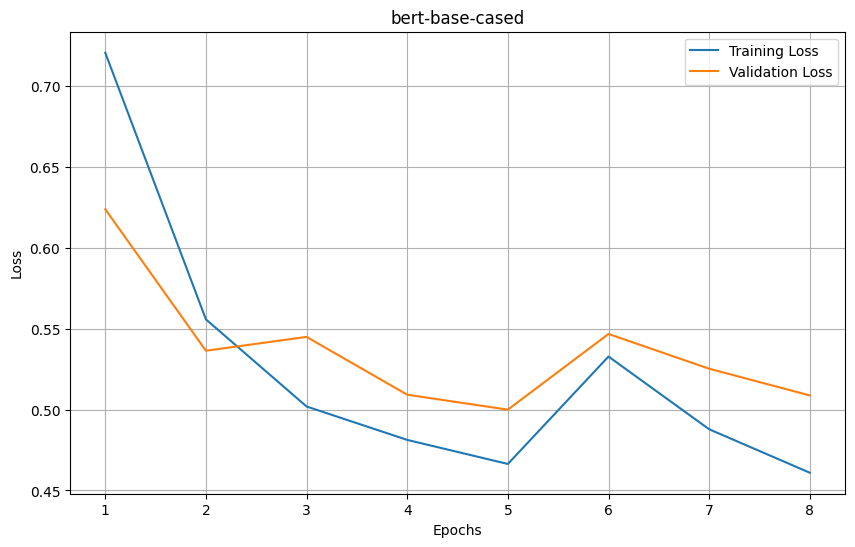

In [98]:
plot_and_save_graph(len(train_losses["loss"]), model_name, train_losses["loss"], val_losses["loss"])

In [99]:
checkpoint = torch.load("./checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
evaluate(test_loader=test_loader, model=model, trainer=trainer, device=accelerator.device)


Test Loss: 0.48904427275475526


tensor([[-0.2303, -0.3660],
        [-0.3230, -0.4289],
        [-0.5505, -0.7071],
        ...,
        [ 2.9516,  1.2367],
        [ 3.5108,  2.5961],
        [ 3.1139,  1.0529]], device='cuda:0', grad_fn=<CatBackward0>)

# BERT large cased

In [100]:
from accelerate import Accelerator
from transformers import AutoTokenizer
import time

model_name = 'bert-large-cased'

max_len = 512 # if bert max 512, if deberta max 1024,
batch_size = 8
test_batch_size = 8


tokenizer = AutoTokenizer.from_pretrained(f"{model_name}")
train_set = SmartBatchingDataset(df=train_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
valid_set = SmartBatchingDataset(df=valid_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
test_set = SmartBatchingDataset(df=test_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)


train_loader = train_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
valid_loader = valid_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
test_loader = test_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)


accelerator = Accelerator(gradient_accumulation_steps=16)

model = RegressorModel(name=model_name, fflayers=4, ffdropout=0.1, freeze_encoder=True,
                       activation_function='relu',features_dim=feature_dim,
                       target_cols=target_cols).to(device=accelerator.device)

trainer = Trainer(model=model, loaders=(train_loader, valid_loader), accelerator=accelerator, epochs=epochs, lr=0.0008, wd=0.015)

multioutput = True

train_losses, val_losses = trainer.fit(multioutput, patience=patience, min_delta=min_delta)

/usr/local/lib/python3.10/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5268 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5268 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/5268 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1433 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1433 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1433 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1147 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1147 [00:00<?, ?it/s]

Epoch: 1/100 Validation Batch:[180/180] training loss: 0.7282631473449004 validation loss: 0.6334286855326758
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 2/100 Validation Batch:[180/180] training loss: 0.5763659389500191 validation loss: 0.5573600990904702
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 3/100 Validation Batch:[180/180] training loss: 0.5254181722498447 validation loss: 0.5592287626531389
Epoch: 4/100 Validation Batch:[180/180] training loss: 0.49577534045000904 validation loss: 0.5167726015051206
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 5/100 Validation Batch:[180/180] training loss: 0.47596783040597335 validation loss: 0.5123176046543652
New best validation loss, saving checkpoint at checkpoint.pt
Epoch: 6/100 Validation Batch:[180/180] training loss: 0.5224096044468409 validation loss: 0.5316331519020928
Epoch: 7/100 Training Batch: [200/659]

KeyboardInterrupt: ignored

In [ ]:
plot_and_save_graph(len(train_losses["loss"]), model_name, train_losses["loss"], val_losses["loss"])

In [ ]:
checkpoint = torch.load("./checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
evaluate(test_loader=test_loader, model=model, trainer=trainer, device=accelerator.device)


# DeBERTa base

In [ ]:
import sentencepiece

model_name = 'microsoft/deberta-v3-base'

max_len = 1024 # if bert max 512, if deberta max 1024,
batch_size = 8
test_batch_size = 8


tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
train_set = SmartBatchingDataset(df=train_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
valid_set = SmartBatchingDataset(df=valid_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
test_set = SmartBatchingDataset(df=test_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)


train_loader = train_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
valid_loader = valid_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
test_loader = test_set.get_dataloader(batch_size=test_batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)


accelerator = Accelerator(gradient_accumulation_steps=16)

model = RegressorModel(name=model_name, fflayers=3, ffdropout=0.1, freeze_encoder=True,
                       activation_function='relu',features_dim=feature_dim,
                       target_cols=target_cols).to(device=accelerator.device)

trainer = Trainer(model=model, loaders=(train_loader, valid_loader), accelerator=accelerator, epochs=epochs, lr=0.001, wd=0.015)

multioutput = True

train_losses, val_losses = trainer.fit(multioutput, patience=patience, min_delta=min_delta)

In [ ]:
plot_and_save_graph(len(train_losses["loss"]), model_name, train_losses["loss"], val_losses["loss"])

In [ ]:
checkpoint = torch.load("./checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
evaluate(test_loader=test_loader, model=model, trainer=trainer, device=accelerator.device)


# DeBERTa large

In [ ]:
from accelerate import Accelerator
from transformers import AutoTokenizer
import time

model_name = 'microsoft/deberta-v3-large'

max_len = 1024 # if bert max 512, if deberta max 1024,
batch_size = 8
test_batch_size = 8


tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
train_set = SmartBatchingDataset(df=train_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
valid_set = SmartBatchingDataset(df=valid_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)
test_set = SmartBatchingDataset(df=test_df, tokenizer=tokenizer, input_cols=input_cols, target_cols=target_cols, features_cols=FEATURE_COLUMNS)


train_loader = train_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
valid_loader = valid_set.get_dataloader(batch_size=batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)
test_loader = test_set.get_dataloader(batch_size=test_batch_size, max_len=max_len,pad_id=tokenizer.pad_token_id)


accelerator = Accelerator(gradient_accumulation_steps=16)

model = RegressorModel(name=model_name, fflayers=4, ffdropout=0.1, freeze_encoder=True,
                       activation_function='relu',features_dim=feature_dim,
                       target_cols=target_cols).to(device=accelerator.device)

trainer = Trainer(model=model, loaders=(train_loader, valid_loader), accelerator=accelerator, epochs=epochs, lr=0.0008, wd=0.01)

multioutput = True

train_losses, val_losses = trainer.fit(multioutput, patience=patience, min_delta=min_delta)

In [ ]:
plot_and_save_graph(len(train_losses["loss"]), model_name, train_losses["loss"], val_losses["loss"])

In [ ]:
checkpoint = torch.load("./checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
evaluate(test_loader=test_loader, model=model, trainer=trainer, device=accelerator.device)
